In [1]:
""""
The most well-known
approaches are described in McCulloch (1971, 1975), Schaefer (1981), Nelson and
Siegel (1987), Deacon and Derry (1994), Adams and Van Deventer (1994) and
Waggoner (1997), to name but a few. The most accessible article is probably the
one by Deacon and Derry.26 In addition a good overview of all the main
approaches is contained in James and Webber (2000), and chapters 15–18 of their
book provide an excellent summary of the research highlights to date
"""

'"\nThe most well-known\napproaches are described in McCulloch (1971, 1975), Schaefer (1981), Nelson and\nSiegel (1987), Deacon and Derry (1994), Adams and Van Deventer (1994) and\nWaggoner (1997), to name but a few. The most accessible article is probably the\none by Deacon and Derry.26 In addition a good overview of all the main\napproaches is contained in James and Webber (2000), and chapters 15–18 of their\nbook provide an excellent summary of the research highlights to date\n'

In [57]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)

import numpy as np
import pandas as pd
import QuantLib as ql
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import scipy.interpolate
from scipy.optimize import newton, fmin_slsqp
from datetime import datetime

from bond_pricing import zero_to_par
from utils.utils import pydatetime_to_quantlib_date, quantlib_date_to_pydatetime
from models.calibrate import calibrate_nss_ols

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
as_of_date = datetime(1997, 6, 27)
data = [
    {"Coupon": "8.75%", "Maturity": "01 Sep 1997", "Market price": "100-11", "Accrued": 2.901, "GRY": 6.411, "Theo Price": 100.315, "Theo GRY": 6.576}, 
    {"Coupon": "9.75%", "Maturity": "19 Jan 1998", "Market price": "101-21", "Accrued": 4.327, "GRY": 6.705, "Theo Price": 101.704, "Theo GRY": 6.616}, 
    {"Coupon": "7.25%", "Maturity": "30 Mar 1998", "Market price": "100-09", "Accrued": 1.827, "GRY": 6.798, "Theo Price": 100.218, "Theo GRY": 6.885}, 
    {"Coupon": "12.25%", "Maturity": "26 Mar 1999", "Market price": "108-14", "Accrued": 3.222, "GRY": 6.972, "Theo Price": 108.486, "Theo GRY": 6.944}, 
    {"Coupon": "6.00%", "Maturity": "10 Aug 1999", "Market price": "98-08", "Accrued": 2.301, "GRY": 6.913, "Theo Price": 98.163, "Theo GRY": 6.958}, 
    {"Coupon": "9.00%", "Maturity": "03 Mar 2000", "Market price": "104-20", "Accrued": 2.934, "GRY": 7.052, "Theo Price": 104.649, "Theo GRY": 7.042}, 
    {"Coupon": "13.00%", "Maturity": "14 Jul 2000", "Market price": "115-28", "Accrued": 5.948, "GRY": 7.115, "Theo Price": 115.941, "Theo GRY": 7.092}, 
    {"Coupon": "8.00%", "Maturity": "07 Dec 2000", "Market price": "102-27", "Accrued": 0.504, "GRY": 7.048, "Theo Price": 102.685, "Theo GRY": 7.100}, 
    {"Coupon": "10.00%", "Maturity": "26 Feb 2001", "Market price": "109-04", "Accrued": 3.397, "GRY": 7.128, "Theo Price": 109.211, "Theo GRY": 7.102}, 
    {"Coupon": "7.00%", "Maturity": "06 Nov 2001", "Market price": "99-22", "Accrued": 1.055, "GRY": 7.073, "Theo Price": 99.690, "Theo GRY": 7.073}, 
    {"Coupon": "7.00%", "Maturity": "07 Jun 2002", "Market price": "99-27", "Accrued": 0.441, "GRY": 7.034, "Theo Price": 99.652, "Theo GRY": 7.081}, 
    {"Coupon": "9.75%", "Maturity": "27 Aug 2002", "Market price": "111-04", "Accrued": 3.286, "GRY": 7.139, "Theo Price": 111.346, "Theo GRY": 7.091}, 
    {"Coupon": "8.00%", "Maturity": "10 Jun 2003", "Market price": "104-10", "Accrued": 0.438, "GRY": 7.095, "Theo Price": 104.249, "Theo GRY": 7.108}, 
    {"Coupon": "9.50%", "Maturity": "25 Oct 2004", "Market price": "113-14", "Accrued": 1.718, "GRY": 7.108, "Theo Price": 113.528, "Theo GRY": 7.093}, 
    {"Coupon": "6.75%", "Maturity": "26 Nov 2004", "Market price": "98-05", "Accrued": 0.647, "GRY": 7.068, "Theo Price": 98.006, "Theo GRY": 7.094}, 
    {"Coupon": "9.50%", "Maturity": "18 Apr 2005", "Market price": "114-02", "Accrued": 1.900, "GRY": 7.115, "Theo Price": 114.167, "Theo GRY": 7.098}, 
    {"Coupon": "8.50%", "Maturity": "07 Dec 2005", "Market price": "108-23", "Accrued": 0.536, "GRY": 7.105, "Theo Price": 108.654, "Theo GRY": 7.115}, 
    {"Coupon": "7.75%", "Maturity": "08 Sep 2006", "Market price": "104-04", "Accrued": 2.421, "GRY": 7.124, "Theo Price": 104.155, "Theo GRY": 7.119}, 
    {"Coupon": "7.50%", "Maturity": "07 Dec 2006", "Market price": "102-21", "Accrued": 0.473, "GRY": 7.106, "Theo Price": 102.594, "Theo GRY": 7.115}, 
    {"Coupon": "8.50%", "Maturity": "16 Jul 2007", "Market price": "109-22", "Accrued": 3.842, "GRY": 7.137, "Theo Price": 109.893, "Theo GRY": 7.109}, 
    {"Coupon": "7.25%", "Maturity": "07 Dec 2007", "Market price": "101-06", "Accrued": 0.457, "GRY": 7.085, "Theo Price": 100.995, "Theo GRY": 7.111}, 
    {"Coupon": "9.00%", "Maturity": "13 Oct 2008", "Market price": "114-08", "Accrued": 1.923, "GRY": 7.136, "Theo Price": 114.271, "Theo GRY": 7.134}, 
    {"Coupon": "8.00%", "Maturity": "25 Sep 2009", "Market price": "106-24", "Accrued": 2.126, "GRY": 7.157, "Theo Price": 106.775, "Theo GRY": 7.154}, 
    {"Coupon": "6.25%", "Maturity": "25 Nov 2010", "Market price": "92-02", "Accrued": 0.616, "GRY": 7.178, "Theo Price": 92.095, "Theo GRY": 7.174}, 
    {"Coupon": "9.00%", "Maturity": "12 Jul 2011", "Market price": "116-01", "Accrued": 4.167, "GRY": 7.173, "Theo Price": 115.987, "Theo GRY": 7.177}, 
    {"Coupon": "9.00%", "Maturity": "06 Aug 2012", "Market price": "116-19", "Accrued": 3.551, "GRY": 7.184, "Theo Price": 116.574, "Theo GRY": 7.186}, 
    {"Coupon": "8.00%", "Maturity": "27 Sep 2013", "Market price": "107-24", "Accrued": 2.082, "GRY": 7.179, "Theo Price": 107.786, "Theo GRY": 7.175}, 
    {"Coupon": "8.00%", "Maturity": "07 Dec 2015", "Market price": "108-23", "Accrued": 0.504, "GRY": 7.140, "Theo Price": 108.702, "Theo GRY": 7.142}, 
    {"Coupon": "8.75%", "Maturity": "25 Aug 2017", "Market price": "116-18", "Accrued": 2.997, "GRY": 7.184, "Theo Price": 116.569, "Theo GRY": 7.183}, 
    {"Coupon": "8.00%", "Maturity": "07 Jun 2021", "Market price": "109-31", "Accrued": 0.504, "GRY": 7.125, "Theo Price": 109.968, "Theo GRY": 7.12}, 
]
df = pd.DataFrame(data)

def convert_market_price(price):
    parts = price.split('-')
    return int(parts[0]) + int(parts[1]) / 32

df['Maturity'] = pd.to_datetime(df['Maturity'], format='%d %b %Y', errors="coerce")
df["label"] = df.apply(lambda row: row["Coupon"] + " " + row["Maturity"].strftime("%m/%d/%Y"), axis=1) 
df['Coupon'] = df['Coupon'].str.rstrip('%').astype(float) / 100
df['Market price'] = df['Market price'].apply(convert_market_price)

df

,Coupon,Maturity,Market price,Accrued,GRY,Theo Price,Theo GRY,label
0,0.0875,1997-09-01,100.34375,2.901,6.411,100.315,6.576,8.75% 09/01/1997
1,0.0975,1998-01-19,101.65625,4.327,6.705,101.704,6.616,9.75% 01/19/1998
2,0.0725,1998-03-30,100.28125,1.827,6.798,100.218,6.885,7.25% 03/30/1998
3,0.1225,1999-03-26,108.43750,3.222,6.972,108.486,6.944,12.25% 03/26/1999
4,0.0600,1999-08-10,98.25000,2.301,6.913,98.163,6.958,6.00% 08/10/1999
5,0.0900,2000-03-03,104.62500,2.934,7.052,104.649,7.042,9.00% 03/03/2000
6,0.1300,2000-07-14,115.87500,5.948,7.115,115.941,7.092,13.00% 07/14/2000
7,0.0800,2000-12-07,102.84375,0.504,7.048,102.685,7.100,8.00% 12/07/2000
8,0.1000,2001-02-26,109.12500,3.397,7.128,109.211,7.102,10.00% 02/26/2001
9,0.0700,2001-11-06,99.68750,1.055,7.073,99.690,7.073,7.00% 11/06/2001


In [67]:
def par_bond_equation(c, maturity, zero_curve_func):
    discounted_cash_flows = sum(
        (c / 2) * np.exp(-(zero_curve_func(t) / 100) * t)
        for t in np.arange(0.5, maturity + 0.5, 0.5)
    )
    final_payment = 100 * np.exp(-(zero_curve_func(maturity) / 100) * maturity)
    return discounted_cash_flows + final_payment - 100


def par_curve_func(tenor, zero_curve_func):
    init_guess = 6
    return newton(par_bond_equation, x0=init_guess, args=(tenor, zero_curve_func))

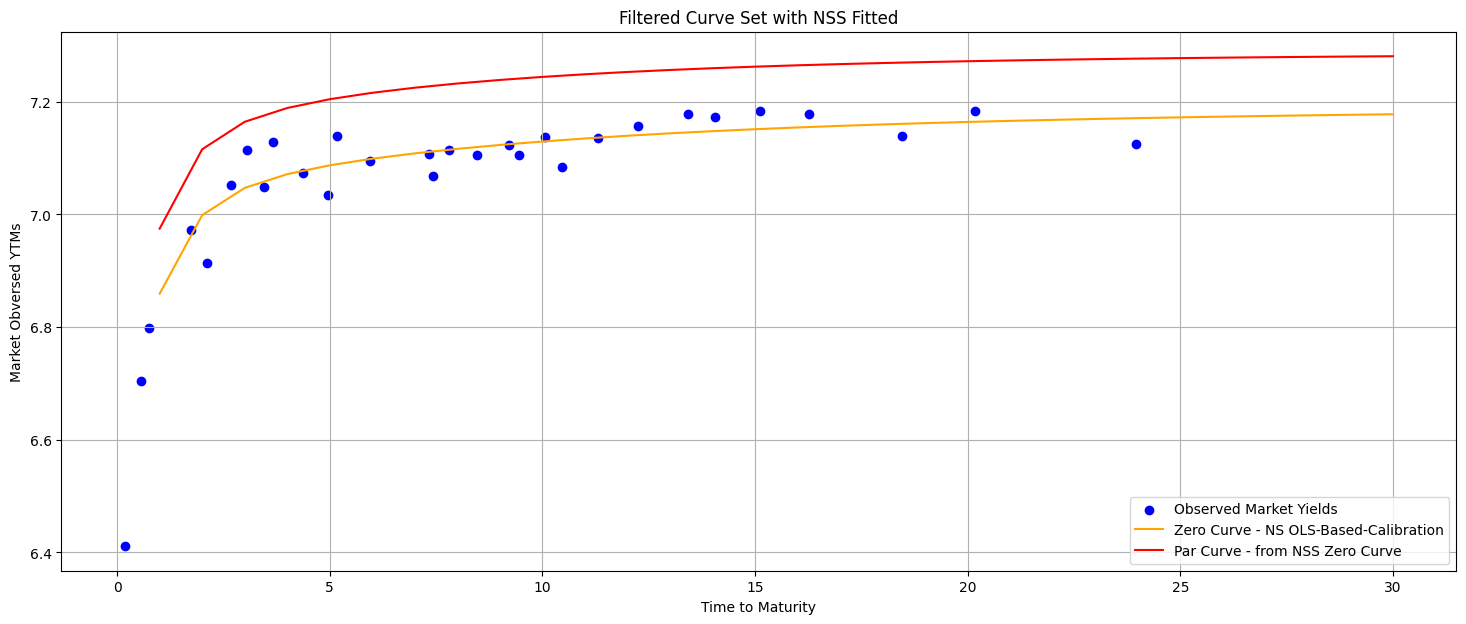

In [71]:
ttm = (df["Maturity"] - as_of_date).dt.days / 365
plt.figure(figsize=(18, 7))
plt.scatter(
    ttm,
    df["GRY"],
    color="blue",
    label="Observed Market Yields",
)
# plt.scatter(
#     ttm,
#     df["Theo GRY"],
#     color="red",
#     label="Theo Market Yields",
# )

ttm_ls = np.linspace(1, 30, 30)

filtered_curve_set_nss_func, status_nss, _ = calibrate_nss_ols(
    ttm.to_numpy(),
    df["GRY"].to_numpy(),
)
plt.plot(ttm_ls, filtered_curve_set_nss_func(ttm_ls), color="orange", label="Zero Curve - NS OLS-Based-Calibration")

plt.plot(ttm_ls, [par_curve_func(t, filtered_curve_set_nss_func) for t in ttm_ls], color="red", label="Par Curve - from NSS Zero Curve")

plt.xlabel("Time to Maturity")
plt.ylabel("Market Obversed YTMs")
plt.title("Filtered Curve Set with NSS Fitted")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
pgbs = df
calendar = ql.TARGET()
today = calendar.adjust(pydatetime_to_quantlib_date(as_of_date))
ql.Settings.instance().evaluationDate = today

bondSettlementDays = 3
bondSettlementDate = calendar.advance(today, ql.Period(bondSettlementDays, ql.Days))
frequency = ql.Annual
dc = ql.ActualActual(ql.ActualActual.ISMA)
accrualConvention = ql.ModifiedFollowing
convention = ql.ModifiedFollowing
redemption = 100.0

instruments = []
for idx, row in pgbs.iterrows():
    maturity = pydatetime_to_quantlib_date(row["Maturity"])
    schedule = ql.Schedule(
        bondSettlementDate,
        maturity,
        ql.Period(frequency),
        calendar,
        accrualConvention,
        accrualConvention,
        ql.DateGeneration.Backward,
        False,
    )
    helper = ql.FixedRateBondHelper(
        ql.QuoteHandle(ql.SimpleQuote(row["GRY"])),
        bondSettlementDays,
        100.0,
        schedule,
        [row["Coupon"]],
        dc,
        convention,
        redemption,
    )

    instruments.append(helper)

params = [bondSettlementDate, instruments, dc]

fittingMethods = {
    "NelsonSiegelFitting": ql.NelsonSiegelFitting(),
    "SvenssonFitting": ql.SvenssonFitting(),
    "SimplePolynomialFitting": ql.SimplePolynomialFitting(2),
    "ExponentialSplinesFitting": ql.ExponentialSplinesFitting(),
    "CubicBSplinesFitting": ql.CubicBSplinesFitting(
        [-20, -10, -5, 0, 1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50]
    ),
}

fittedBondCurveMethods = {
    label: ql.FittedBondDiscountCurve(*params, method)
    for label, method in fittingMethods.items()
}

In [12]:
method = "SvenssonFitting"
curve = fittedBondCurveMethods.get(method)
curve.enableExtrapolation()

dates = [
    bondSettlementDate + ql.Period(i, ql.Months) for i in range(0, 12 * 20, 1)
]
print(dates)

ttm = [(ql.Date.to_date(d) - ql.Date.to_date(bondSettlementDate)).days / 365 for d in dates]
eq_zero_rates = []
for d in dates:
    yrs = (ql.Date.to_date(d) - ql.Date.to_date(bondSettlementDate)).days / 365.0
    zero_rate = curve.zeroRate(yrs, ql.Continuous, True)
    eq_rate = zero_rate.equivalentRate(
        dc, ql.Continuous, ql.NoFrequency, bondSettlementDate, d
    ).rate()
    eq_zero_rates.append(eq_rate)


fig = go.Figure()


fig.add_trace(go.Scatter(
    x=ttm,
    y=eq_zero_rates,
    mode='lines',
    name=f'Zero Curve {method} - QL (from eq zero)'
))

t2 = np.linspace(0, 30, 1000)
fig.add_trace(go.Scatter(
    x=t2,
    y=li_eq_zero_rates_func(t2),
    mode='lines',
    name=f'Zero Curve {method} - INTERP (from eq zero)'
))

# fig.add_trace(go.Scatter(
#     x=t2,
#     y=fitted_zero_curve_func_nss(t2),
#     mode='lines',
#     name=f'Zero Curve {method} - calc'
# ))

fig.update_layout(
    title="Fitted Bond Discount Curve",
    xaxis_title="Time to Maturity (Years)",
    yaxis_title="Zero Rate (%)",
    legend_title="Curve",
    width=1600,
    height=800,
    template="plotly_dark",
)

fig.update_xaxes(
    showgrid=True,
    showspikes=True,
    spikecolor="white",
    spikesnap="cursor",
    spikemode="across",
)
fig.update_yaxes(showgrid=True, showspikes=True, spikecolor="white", spikethickness=1)

fig.show()

[Date(2,7,1997), Date(2,8,1997), Date(2,9,1997), Date(2,10,1997), Date(2,11,1997), Date(2,12,1997), Date(2,1,1998), Date(2,2,1998), Date(2,3,1998), Date(2,4,1998), Date(2,5,1998), Date(2,6,1998), Date(2,7,1998), Date(2,8,1998), Date(2,9,1998), Date(2,10,1998), Date(2,11,1998), Date(2,12,1998), Date(2,1,1999), Date(2,2,1999), Date(2,3,1999), Date(2,4,1999), Date(2,5,1999), Date(2,6,1999), Date(2,7,1999), Date(2,8,1999), Date(2,9,1999), Date(2,10,1999), Date(2,11,1999), Date(2,12,1999), Date(2,1,2000), Date(2,2,2000), Date(2,3,2000), Date(2,4,2000), Date(2,5,2000), Date(2,6,2000), Date(2,7,2000), Date(2,8,2000), Date(2,9,2000), Date(2,10,2000), Date(2,11,2000), Date(2,12,2000), Date(2,1,2001), Date(2,2,2001), Date(2,3,2001), Date(2,4,2001), Date(2,5,2001), Date(2,6,2001), Date(2,7,2001), Date(2,8,2001), Date(2,9,2001), Date(2,10,2001), Date(2,11,2001), Date(2,12,2001), Date(2,1,2002), Date(2,2,2002), Date(2,3,2002), Date(2,4,2002), Date(2,5,2002), Date(2,6,2002), Date(2,7,2002), Date(2,8